# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# magic word for producing visualizations in notebook
%matplotlib inline
import markdown
from bs4 import BeautifulSoup
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias.shape)
azdias.head()

(891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
# first rows of feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,X]       1
[-1,XX]      1
[XX]         1
[-1,0,9]     1
Name: missing_or_unknown, dtype: int64

In [6]:
# Data has naturally missing NaN values?
azdias.isnull().values.any()

True

In [7]:
# total natural nan in database
natural_nan_total = azdias.isnull().sum().sum()
natural_nan_total

4896838

In [8]:
# types of data missing or unknown
feat_info.type.unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [9]:
# example of missing_or_unknown that is type numeric
feat_info[feat_info["type"] == "mixed"]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [10]:
# value of unique elements in one row mixed
azdias.CAMEO_INTL_2015.value_counts(dropna=False)

51     133694
NaN     98979
41      92336
24      91158
14      62884
43      56672
54      45391
25      39628
22      33155
23      26750
13      26336
45      26132
55      23955
52      20542
31      19024
34      18524
15      16974
44      14820
12      13249
35      10356
32      10354
33       9935
XX        373
Name: CAMEO_INTL_2015, dtype: int64

In [11]:
# example of missing_or_unknown that is type ordinal
feat_info[feat_info["type"] == "ordinal"].head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]


In [12]:
# value of unique elements in one row ordinal
azdias.ALTERSKATEGORIE_GROB.value_counts(dropna=False)

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [13]:
# example of missing_or_unknown that is type categorical
feat_info[feat_info["type"] == "categorical"].head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]


In [14]:
# value of unique elements in one row categorial
azdias.AGER_TYP.value_counts(dropna=False)

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

In [15]:
# value of unique elements in one row categorial
azdias.GFK_URLAUBERTYP.value_counts(dropna=False)

 12.0    138545
 5.0     120126
 10.0    109127
 8.0      88042
 11.0     79740
 4.0      63770
 9.0      60614
 3.0      56007
 1.0      53600
 2.0      46702
 7.0      42956
 6.0      27138
NaN        4854
Name: GFK_URLAUBERTYP, dtype: int64

Different groups, with different values used to indicate missing or unknown

In [16]:
# change missing_or_unknown string [] to list
# function modified from Udacity Knowledge

def string_to_list(x):

    new_list=[]

    x = x[1:-1].split(',')

    for i in x:
            try:
                new_list.append(int(i))
            except:
                new_list.append(i)
    
    return new_list

feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_to_list)

feat_info.head()

,attribute,information_level,type,missing_or_unknown,NA_tags
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]


In [17]:
# change missing or unknown values by np.nan
att_index = feat_info.set_index('attribute')

for column in azdias.columns:
    azdias[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
    
azdias.isna().sum().sum()

8373929

In [18]:
# example of value of unique elements in one row mixed
# NaN but not XX values
azdias.CAMEO_INTL_2015.value_counts(dropna=False)

51     133694
NaN     99352
41      92336
24      91158
14      62884
43      56672
54      45391
25      39628
22      33155
23      26750
13      26336
45      26132
55      23955
52      20542
31      19024
34      18524
15      16974
44      14820
12      13249
35      10356
32      10354
33       9935
Name: CAMEO_INTL_2015, dtype: int64

In [19]:
# value of unique elements in one row categorial
# NaN instead of -1
azdias.AGER_TYP.value_counts(dropna=False)

NaN     685843
 2.0     98472
 1.0     79802
 3.0     27104
Name: AGER_TYP, dtype: int64

In [20]:
# value of unique elements in one row ordinal
# NaN instead of 9
azdias.ALTERSKATEGORIE_GROB.value_counts(dropna=False)

 3.0    358533
 4.0    228510
 2.0    158410
 1.0    142887
NaN       2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

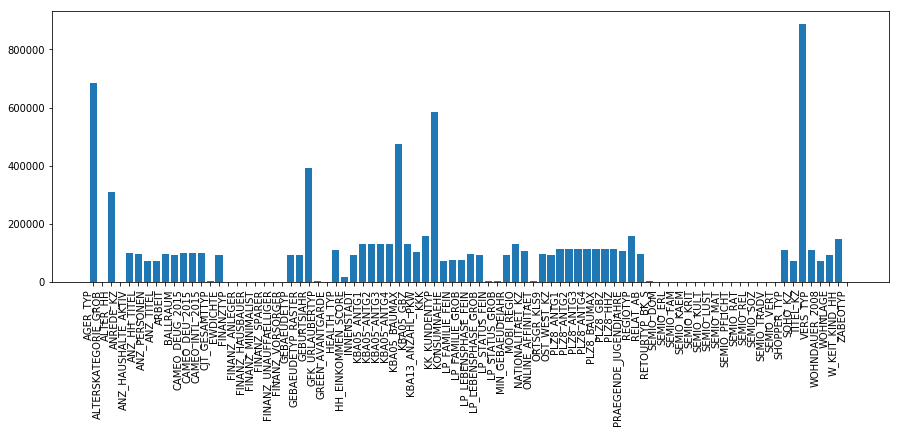

In [21]:
# total NaN per column after correct missing values
total_nan_col = azdias.isnull().sum()
plt.figure(figsize=[15,5])
plt.bar(total_nan_col.index, total_nan_col.values)
plt.xticks(rotation=90, ha='right')
plt.show()

In [22]:
# total Nan in database
total_nan = total_nan_col.sum()
total_nan

8373929

In [23]:
print("Total number of natural Nan: ", natural_nan_total)
print("Total number of missing or unknown data:", total_nan)
print("Ratio: ", total_nan/natural_nan_total)

Total number of natural Nan:  4896838
Total number of missing or unknown data: 8373929
Ratio:  1.71006861979


In [24]:
print("Step 1.1.1: Convert Missing Value Codes to NaNs, rows : {}, columns: {}".format(azdias.shape[0], azdias.shape[1]))

Step 1.1.1: Convert Missing Value Codes to NaNs, rows : 891221, columns: 85


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

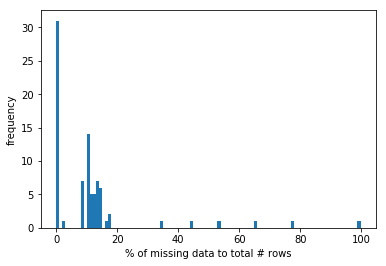

In [25]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# total NaN per column
total_nan_col = azdias.isnull().sum()
per_total_nan_col = (total_nan_col/len(azdias.index))*100

# Investigate patterns in the amount of missing data in each column.
plt.hist(per_total_nan_col, bins=100)
plt.xlabel("% of missing data to total # rows")
plt.ylabel("frequency")
plt.show()

In [26]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# column outliers
outliers = per_total_nan_col[per_total_nan_col > 20]
outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

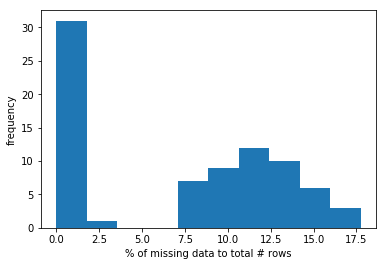

In [27]:
# remove outliers
azdias.drop(columns=outliers.index.tolist(), inplace= True)

# plot distribution of missing values
keepers = azdias.isnull().sum()
plt.hist((keepers/len(azdias.index))*100)
plt.xlabel("% of missing data to total # rows")
plt.ylabel("frequency")
plt.show()

In [28]:
print("Step 1.1.2: Assess Missing Data in Each Column, rows : {}, columns: {}".format(azdias.shape[0], azdias.shape[1]))

Step 1.1.2: Assess Missing Data in Each Column, rows : 891221, columns: 79


#### Discussion 1.1.2: Assess Missing Data in Each Column

We have 2 groups of less than 20% missing data and 6 features with 20% or more missing data.

The columns AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP and KBA05_BAUMAX had 20% or more missing data, and they were discarded.

From the rest of the data, we can see two groups, oune with around 1% of missing data, and another with around 12% of missing data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

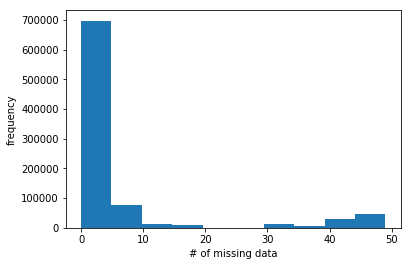

In [29]:
# How much data is missing in each row of the dataset?
total_nan_row = azdias.isnull().sum(axis=1)

# histo of empty rows
plt.hist(total_nan_row)
plt.xlabel("# of missing data")
plt.ylabel("frequency")
plt.show()

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 25

subset1 = azdias[total_nan_row <= threshold]
azdias_show = azdias.copy()
azdias_show['subset'] = total_nan_row > threshold

subset1.shape[0]

797961

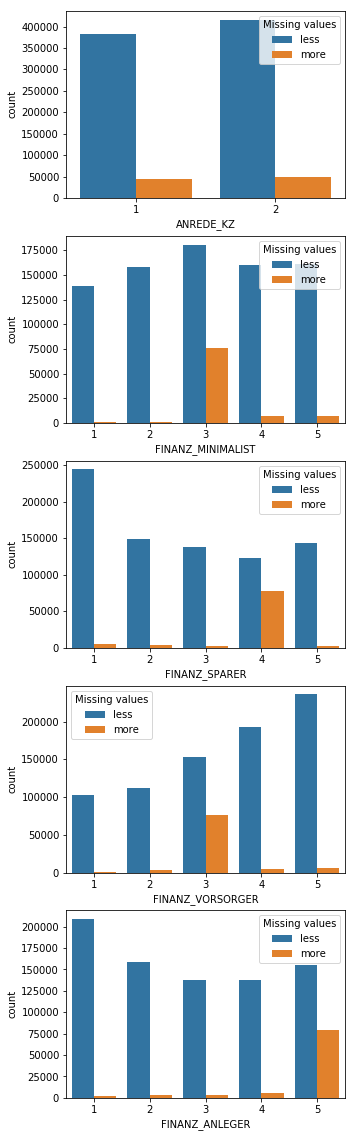

In [31]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# columns with no missing values
zero_miss =total_nan_col[total_nan_col == 0].axes[0].tolist()

fig, axes = plt.subplots(5,1)
fig.set_figheight(20)
fig.set_figwidth(5)

for i in np.arange(5):
    g = sns.countplot(ax=axes[i], x=zero_miss[i], data=azdias_show, hue = "subset")
    g.legend(labels=["less","more"], title = "Missing values")

In [32]:
print("Step 1.1.3: Assess Missing Data in Each row, rows : {}, columns: {}".format(subset1.shape[0], subset1.shape[1]))

Step 1.1.3: Assess Missing Data in Each row, rows : 797961, columns: 79


#### Discussion 1.1.3: Assess Missing Data in Each Row

We found 2 groups of data with missing values in rows, and we divided the dataset in those with rows with 25 or less missing values and those with more than 25 missing values.

We found that a qualitative difference in the distribution of values between those datasets if we compare 5 features with no missing values. For example in the feature FINANZ_SPARER the dataset with less missing values has a distribution that tends towards 1.0, while the dataset with more missing values tends towards 4.0. We also see differences in distribution in the features FINANZ_VORSORGER and in FINANZ_ANLEGER.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
# remove outliers
for column in outliers.index.tolist():
    feat_info = feat_info[feat_info.attribute != column]
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()

# count categorical variables
cat_variables = subset1[categorical].nunique()

In [35]:
# binary categorical variables
binary = cat_variables[cat_variables <= 2]
binary

ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64

In [36]:
# find the non-numerical binary categorical feature
subset1[binary.index.tolist()].dtypes

ANREDE_KZ             int64
GREEN_AVANTGARDE      int64
SOHO_KZ             float64
VERS_TYP            float64
OST_WEST_KZ          object
dtype: object

In [37]:
# what values has the categorical feature with not-numerical values
subset1['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [38]:
# Re-encode categorical variable(s) to be kept in the analysis.
subset1['OST_WEST_KZ'] = subset1['OST_WEST_KZ'].replace(['W', 'O'], [0, 1])
subset1['OST_WEST_KZ'].unique()


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


array([0, 1])

In [39]:
# multilevel categorical variables
multilevel = cat_variables[cat_variables > 2].index.tolist()
multilevel

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [40]:
# remove multilevel categorical variables
multilevel = cat_variables[cat_variables > 2].index.tolist()
subset1 = subset1.drop(columns=multilevel)
for column in multilevel:
    feat_info= feat_info[feat_info.attribute != column]

In [41]:
print("1.2.1: Re-Encode Categorical Features, rows : {}, columns: {}".format(subset1.shape[0], subset1.shape[1]))

1.2.1: Re-Encode Categorical Features, rows : 797961, columns: 66


#### Discussion 1.2.1: Re-Encode Categorical Features

I found 19 categorical features, from which 14 where multilevel and were discarded.

From the 5 binary categorical features, 4 where float64, but 1 was an object. I changed the values of that feature to 0 and 1.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [42]:
import re
# load dictionary
html = markdown.markdown(open("Data_Dictionary.md").read())
# parse the html using beautiful soup and store in variable `soup`
soup = BeautifulSoup(html, 'html.parser')

print(soup.prettify())

<h1>
 Data Dictionary for Identify Customer Segments Data
</h1>
<h2>
 Introduction
</h2>
<p>
 The data for this project consist of two files:
</p>
<ul>
 <li>
  Udacity_AZDIAS_Subset.csv: demographics data for the general population of
      Germany; 891211 persons (rows) x 85 features (columns)
 </li>
 <li>
  Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order
      company; 191652 persons (rows) x 85 features (columns)
 </li>
</ul>
<p>
 The columns in the general demographics file and customers data file are the
same. This file documents the features that appear in the data files, sorted in
order of appearance. Sections of this file is based on the level of measurement
of each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of
feature attributes, including information level, data type, and codes for
missing or unknown values.
</p>
<h3>
 Table of Contents
</h3>
<ol>
 <li>
  Person-level features
 </li>
 <li>
  Household-level features
 </li>


In [43]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
'''
1.18. PRAEGENDE_JUGENDJAHRE
</h3>
<p>
 Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''
# unique values in 'PRAEGENDE_JUGENDJAHRE'
subset1['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   5.,   9.,   6.,   4.,  nan,
         2.,   1.,  12.,  13.,   7.])

In [44]:
# need to get new variables for an interval-type variable for decade, 
# and a binary variable for movement.
# all possible values

range_variables = np.arange(-1,16)
decades = [np.nan, np.nan, 40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
movs = [np.nan, np.nan, 0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]

dict_decade = dict(zip(range_variables, decades))

# mainstream : 0, avantgarden : 1
dict_mov = dict(zip(range_variables, movs))

'''
dict_decade = {-1.0: np.nan,
            0.0: np.nan,
              1.0: 40,
              2.0: 40,
              3.0: 50,
              4.0: 50,
              5.0: 60,
              6.0: 60,
              7.0: 60,
              8.0: 70,
              9.0: 70,
              10.0: 80,
              11.0: 80,
              12.0: 80,
              13.0: 80,
              14.0: 90,
              15.0: 90,
              np.nan: np.nan}

# mainstream : 0, avantgarden : 1
dict_mov = {-1.0: np.nan,
            0.0: np.nan,
              1.0: 0,
              2.0: 1,
              3.0: 0,
              4.0: 1,
              5.0: 0,
              6.0: 1,
              7.0: 1,
              8.0: 0,
              9.0: 1,
              10.0: 0,
              11.0: 1,
              12.0: 0,
              13.0: 1,
              14.0: 0,
              15.0: 1}
'''
decade = []
movement = []
for a in np.array(subset1['PRAEGENDE_JUGENDJAHRE']):
    if math.isnan(a):
        decade.append(np.nan)
        movement.append(np.nan)
    else:
        decade.append(dict_decade[a])
        movement.append(dict_mov[a])

subset1['PRAEGENDE_JUGENDJAHRE_DEC'] = decade
subset1['PRAEGENDE_JUGENDJAHRE_MOV'] = movement

In [45]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
'''
4.3. CAMEO_INTL_2015
</h3>
<p>
 German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples &amp; Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &amp;  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples &amp; Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families &amp; Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples &amp; Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families &amp; Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples &amp; Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families &amp; Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples &amp; Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families &amp; Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
</p>
'''
# unique values in 'CAMEO_INTL_2015'
subset1['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', nan, '25', '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [46]:
'''
"CAMEO_INTL_2015" combines information on two axes: wealth and life stage. 
    Break up the two-digit codes by their 'tens'-place and 'ones'-place 
    digits into two new ordinal variables (which, for the purposes of 
    this project, is equivalent to just treating them as their 
    raw numeric values).
'''
ones = []
tens = []
for a in subset1['CAMEO_INTL_2015']:
    a = float(a)
    if math.isnan(a):
        ones.append(np.nan)
        tens.append(np.nan)
    else:
        ones.append(a%10)
        tens.append(int(a/10))

subset1['CAMEO_INTL_2015_ONES'] = ones
subset1['CAMEO_INTL_2015_TENS'] = tens

In [47]:
# other mixed features
mixed = feat_info[feat_info['type'] == 'mixed'].attribute.tolist()

# count categorical variables
mix_variables = subset1[mixed].nunique()
mix_variables

LP_LEBENSPHASE_FEIN      40
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
WOHNLAGE                  8
CAMEO_INTL_2015          21
PLZ8_BAUMAX               5
dtype: int64

In [48]:
'''
1.11. LP_LEBENSPHASE_FEIN
</h3>
<p>
 Life stage, fine scale
-  1: single low-income earners of younger age
-  2: single low-income earners of middle age
-  3: single average earners of younger age
-  4: single average earners of middle age
-  5: single low-income earners of advanced age
-  6: single low-income earners at retirement age
-  7: single average earners of advanced age
-  8: single average earners at retirement age
-  9: single independent persons
- 10: wealthy single homeowners
- 11: single homeowners of advanced age
- 12: single homeowners at retirement age
- 13: single top earners of higher age
- 14: low-income and average earner couples of younger age
- 15: low-income earner couples of higher age
- 16: average earner couples of higher age
- 17: independent couples
- 18: wealthy homeowner couples of younger age
- 19: homeowner couples of higher age
- 20: top earner couples of higher age
- 21: single parent low-income earners
- 22: single parent average earners
- 23: single parent high-income earners
- 24: low-income earner families
- 25: average earner families
- 26: independent families
- 27: homeowner families
- 28: top earner families
- 29: low-income earners of younger age from multiperson households
- 30: average earners of younger age from multiperson households
- 31: low-income earners of higher age from multiperson households
- 32: average earners of higher age from multiperson households
- 33: independent persons of younger age from multiperson households
- 34: homeowners of younger age from multiperson households
- 35: top earners of younger age from multiperson households
- 36: independent persons of higher age from multiperson households
- 37: homeowners of advanced age from multiperson households
- 38: homeowners at retirement age from multiperson households
- 39: top earners of middle age from multiperson households
- 40: top earners at retirement age from multiperson households
</p>
'''
subset1['LP_LEBENSPHASE_FEIN'].unique()

array([ 21.,   3.,  nan,  32.,   8.,   2.,   5.,  10.,   4.,   6.,  23.,
        12.,  20.,   1.,  11.,  25.,  13.,  18.,  31.,  38.,  35.,  30.,
         7.,  22.,  14.,  29.,  24.,  28.,  37.,  26.,  39.,  27.,  36.,
         9.,  34.,  33.,  15.,  40.,  16.,  19.,  17.])

In [49]:
'''
1.12. LP_LEBENSPHASE_GROB
</h3>
<p>
 Life stage, rough scale
-  1: single low-income and average earners of younger age
-  2: single low-income and average earners of higher age
-  3: single high-income earners
-  4: single low-income and average-earner couples
-  5: single high-income earner couples
-  6: single parents
-  7: single low-income and average earner families
-  8: high-income earner families
-  9: average earners of younger age from multiperson households
- 10: low-income and average earners of higher age from multiperson households
- 11: high-income earners of younger age from multiperson households
- 12: high-income earners of higher age from multiperson households
</p>
'''

subset1['LP_LEBENSPHASE_GROB'].unique()

array([  6.,   1.,  nan,  10.,   2.,   3.,   5.,   7.,  12.,  11.,   9.,
         4.,   8.])

In [50]:
# remove 'LP_LEBENSPHASE_FEIN', similar information 
# than 'LP_LEBENSPHASE_GROB'
subset1 = subset1.drop(columns='LP_LEBENSPHASE_FEIN')

In [51]:
'''
3.7. WOHNLAGE
</h3>
<p>
 Neighborhood quality (or rural flag)
- -1: unknown
-  0: no score calculated
-  1: very good neighborhood
-  2: good neighborhood
-  3: average neighborhood
-  4: poor neighborhood
-  5: very poor neighborhood
-  7: rural neighborhood
-  8: new building in rural neighborhood
</p>
'''

subset1['WOHNLAGE'].unique()

array([ 4.,  2.,  7.,  3.,  5.,  1.,  8.,  0.])

In [52]:
'''
8.6. PLZ8_BAUMAX
</h3>
<p>
 Most common building type within the PLZ8 region
- -1: unknown
-  0: unknown
-  1: mainly 1-2 family homes
-  2: mainly 3-5 family homes
-  3: mainly 6-10 family homes
-  4: mainly 10+ family homes
-  5: mainly business buildings
</p>
'''

subset1['PLZ8_BAUMAX'].unique()

array([  1.,   2.,  nan,   4.,   5.,   3.])

In [53]:
print("Step 1.2.2: Engineer Mixed-Type Features, rows : {}, columns: {}".format(subset1.shape[0], subset1.shape[1]))

Step 1.2.2: Engineer Mixed-Type Features, rows : 797961, columns: 69


#### Discussion 1.2.2: Engineer Mixed-Type Features


I dropped 'LP_LEBENSPHASE_FEIN', because has similar information from 'LP_LEBENSPHASE_GROB'

For 'PRAEGENDE_JUGENDJAHRE' I created 'PRAEGENDE_JUGENDJAHRE_DEC' and 'PRAEGENDE_JUGENDJAHRE_MOV' that store the decade (50, 60, 70, 80, 90) and the movement (0 and 1).

For 'CAMEO_INTL_2015' I created 'CAMEO_INTL_2015_ONES' and 'CAMEO_INTL_2015_TENS' to store the year and decade

I kept all the other mixed features.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# remove original columns re-engineering
re_engineered = ['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
subset1 = subset1.drop(columns=re_engineered)

for column in re_engineered:
    feat_info= feat_info[feat_info.attribute != column]

In [55]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
feat_info.type.value_counts()

ordinal        49
numeric         6
categorical     5
mixed           4
Name: type, dtype: int64

In [56]:
# categorical feautures should be binary and numeric
categorical = feat_info[feat_info.type == 'categorical'].attribute.tolist()
for column in categorical:
    print(column + ': ' + str(len(subset1[column].unique())) + ' ' + str(subset1[column].dtype))

ANREDE_KZ: 2 int64
GREEN_AVANTGARDE: 2 int64
SOHO_KZ: 2 float64
VERS_TYP: 3 float64
OST_WEST_KZ: 2 int64


In [57]:
subset1['VERS_TYP'].value_counts(dropna=False)

 2.0    394229
 1.0    367052
NaN      36680
Name: VERS_TYP, dtype: int64

In [58]:
# remove 'VERS_TYP' because is not binary, has some Nan
feat_info= feat_info[feat_info.attribute != 'VERS_TYP']
subset1 = subset1.drop(columns = 'VERS_TYP')

In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

def check_columns(type_feature):
    
    columns = feat_info[feat_info.type == 'type_feature'].attribute.tolist()

    for column in columns:
        if not column in subset1.columns:
            print("missing :", column)

check_columns('numeric')
check_columns('interval')
check_columns('ordinal')

In [60]:
print("Step 1.2.3: Complete Feature Selection, rows : {}, columns: {}".format(subset1.shape[0], subset1.shape[1]))

Step 1.2.3: Complete Feature Selection, rows : 797961, columns: 66


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [61]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # remove outliers
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    # Load in the feature summary file.
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')
    
    # get only columns in df
    all_columns = feat_info.attribute.tolist()
    # series of column names
    col_names = df.columns
        
    for column in all_columns:
        if column not in col_names:
            feat_info= feat_info[feat_info.attribute != column] 
    
    feat_info['NA_tags'] = feat_info['missing_or_unknown'].apply(string_to_list)

    # change missing or unknown values by np.nan in each column
    att_index = feat_info.set_index('attribute')

    for column in df.columns:
        df[column].replace(att_index.loc[column].loc['NA_tags'],np.NaN,inplace=True)
          
    
    # selected columns
    # removing selected columns i.e. rows having > 20% of missing values

    outliers = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH',
                  'KK_KUNDENTYP','KBA05_BAUMAX']
    
    df.drop(columns=outliers, inplace= True)
    
    for column in outliers:
        feat_info= feat_info[feat_info.attribute != column]
        
        
    # rows to remove with more than 25 nan
    total_nan_row = df.isnull().sum(axis=1)
    threshold = 25
    subset = df[total_nan_row <= threshold]
    
    # remove multilevel categorical variables
    categorical = feat_info[feat_info['type'] == 'categorical'].attribute.tolist()
    
    cat_variables = df[categorical].nunique()
    multilevel = cat_variables[cat_variables > 2].index.tolist()
    subset = subset.drop(columns=multilevel)
    
    for column in multilevel:
        feat_info= feat_info[feat_info.attribute != column]
    
    
    if 'LP_LEBENSPHASE_FEIN' in subset:
        subset = subset.drop(columns='LP_LEBENSPHASE_FEIN')
    
    
    # select, re-encode, and engineer column values.
    # Re-encode categorical variable(s) to be kept in the analysis.
    
    if 'OST_WEST_KZ' in subset:
        subset['OST_WEST_KZ'] = subset['OST_WEST_KZ'].replace(['W', 'O'], [0, 1])
    
    
    # correct 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
    range_variables = np.arange(-1,16)
    decades = [np.nan, np.nan, 40, 40, 50, 50, 60, 60, 60, 70, 70, 80, 80, 80, 80, 90, 90]
    movs = [np.nan, np.nan, 0,1,0,1,0,1,1,0,1,0,1,0,1,0,1]

    dict_decade = dict(zip(range_variables, decades))

    # mainstream : 0, avantgarden : 1
    dict_mov = dict(zip(range_variables, movs))
        
    
    if 'PRAEGENDE_JUGENDJAHRE' in subset:
        decade = []
        movement = []
        for a in np.array(subset['PRAEGENDE_JUGENDJAHRE']):
            if math.isnan(a):
                decade.append(np.nan)
                movement.append(np.nan)
            else:
                decade.append(dict_decade[a])
                movement.append(dict_mov[a])

        subset['PRAEGENDE_JUGENDJAHRE_DEC'] = decade
        subset['PRAEGENDE_JUGENDJAHRE_MOV'] = movement
        subset = subset.drop(columns = 'PRAEGENDE_JUGENDJAHRE')

        ones = []
        tens = []
    
    if 'CAMEO_INTL_2015' in subset:
        for a in subset['CAMEO_INTL_2015']:
            a = float(a)
            if math.isnan(a):
                ones.append(np.nan)
                tens.append(np.nan)
            else:
                ones.append(a%10)
                tens.append(int(a/10))

        subset['CAMEO_INTL_2015_ONES'] = ones
        subset['CAMEO_INTL_2015_TENS'] = tens
        subset = subset.drop(columns = 'CAMEO_INTL_2015')
    
    if 'VERS_TYP' in subset:
        subset = subset.drop(columns='VERS_TYP')
          
    # Return the cleaned dataframe.
    return subset
   

In [62]:
# test clean_data() function
# Load in the general demographics data.
# function adapted from Udacity feedback
azdias_0 = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

azdias_clean_data = clean_data(azdias_0)


assert azdias_clean_data.shape[0] == subset1.shape[0], "clean_data function is not working properly, rows mismatch"
assert azdias_clean_data.shape[1] == subset1.shape[1], "clean_data function is not working properly, columns mismatch"
print("If this is all you see, you passed the tests")

If this is all you see, you passed the tests


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
subset1.isnull().values.any()

True

In [64]:
# % of rows with nan
(len(subset1[subset1.isnull().any(axis=1)])/len(subset1.index))*100

21.899691839576118

In [65]:
# subset without any nan value
subset1_clean = subset1[~subset1.isnull().any(axis=1)]
subset1_clean.isnull().values.any()

False

In [66]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
#df_columns = subset1_clean.columns
scaler.fit(subset1_clean)
#subset1_scaled = subset1_clean.copy()
subset1_scaled = scaler.transform(subset1_clean)
subset1_scaled.shape

(623210, 66)

### Discussion 2.1: Apply Feature Scaling

the dataset had 21% of rows with nan values, so I removed those.
I used StandardScaler(), and fit_() and transform() for feature scaling (mean 0 and standard deviation 1)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [67]:
# Apply PCA to the data.
pca = PCA(n_components=66)
pca.fit_transform(subset1_scaled)

array([[  3.48498699e+00,  -2.85922762e+00,  -3.06177100e+00, ...,
          1.89911912e-01,   1.31991823e-01,   1.17750659e-14],
       [ -9.37551997e-01,   2.35545449e-01,  -3.03889227e+00, ...,
          3.06961962e-02,   2.20654305e-02,  -4.52193524e-14],
       [  3.21818268e-01,   1.13799170e-01,   3.18701465e+00, ...,
          4.75367859e-01,   3.44632436e-01,   3.36972612e-14],
       ..., 
       [  3.47661316e+00,  -1.99874795e+00,  -3.65724795e+00, ...,
          6.10622281e-01,  -1.20913824e-01,   3.76584566e-16],
       [  5.91201493e+00,  -3.34564688e+00,   2.14808205e+00, ...,
          3.88183097e-01,  -2.19176824e-01,  -8.46302917e-16],
       [ -7.54270899e-01,   9.83768899e-01,   2.88036632e+00, ...,
          8.22561420e-01,   2.88786317e-01,   9.17666336e-17]])

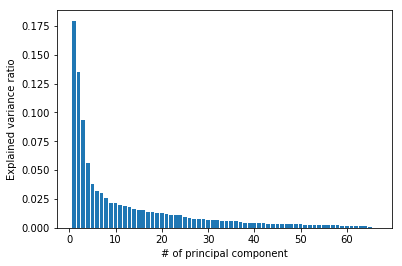

In [68]:
# Investigate the variance accounted for by each principal component.
plt.bar(np.arange(1,67), pca.explained_variance_ratio_)
plt.xlabel("# of principal component")
plt.ylabel("Explained variance ratio")
plt.show()

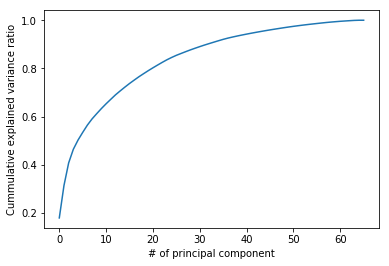

In [69]:
# Investigate the variance accounted for by each principal component.
# cummulative variance explained
cum_sums = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_sums)
plt.xlabel("# of principal component")
plt.ylabel("Cummulative explained variance ratio")
plt.show()

In [70]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_reduced = PCA(n_components=22)
pca_reduced.fit(subset1_scaled)
pca_general_pop = pca_reduced.transform(subset1_scaled)

print("Shape dim reduced data: ", pd.DataFrame(pca_general_pop).shape)

print("Cummulative explained variance ratio: ", np.sum(pca_reduced.explained_variance_ratio_))

Shape dim reduced data:  (623210, 22)
Cummulative explained variance ratio:  0.814017938277


### Discussion 2.2: Perform Dimensionality Reduction


The dataset had 68 features, and using all those features the plot of the cummulative explained variance ratio versus # principal component shows the first 22 features account for the majority of the variance (80%) and I will retain only those for the next step of the analysis

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [71]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# function for mapping and print linked values, sorted by weight
def map_weight(components = pca_reduced.components_, dataset = subset1_clean, 
               pc = 1):
    pc_data = pd.DataFrame(components,columns=dataset.columns)
    result = pc_data.iloc[pc-1].sort_values(ascending=False)
    arr = np.hstack((result.index.tolist()[:3], result.index.tolist()[-3:]))
    arr2 = np.hstack((result[:3].tolist(), result[-3:].tolist()))
    return arr, arr2


#pc_data = pd.DataFrame(pca_reduced.components_,columns=subset1_scaled.columns)

In [72]:
#pc_data.head()

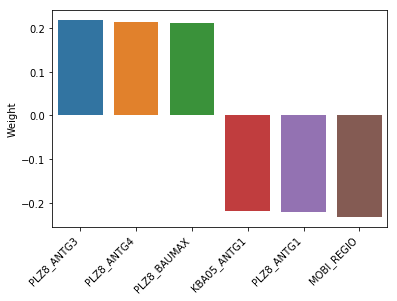

In [73]:
pc1 = map_weight(pc=1)

sns.barplot(pc1[0],pc1[1])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Weight")

plt.show()

PLZ8_ANTG3:  Number of 6-10 family houses in the PLZ8 region

PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region

PLZ8_BAUMAX: Most common building type within the PLZ8 region

KBA05_ANTG1: number of 1-2 family houses in the microcell

PLZ8_ANTG1:  Number of 1-2 family houses in the PLZ8 region

MOBI_REGIO: Movement patterns

PC1 related to building and how many families live in a single unit. Negative correlation between more and less families living in a unit

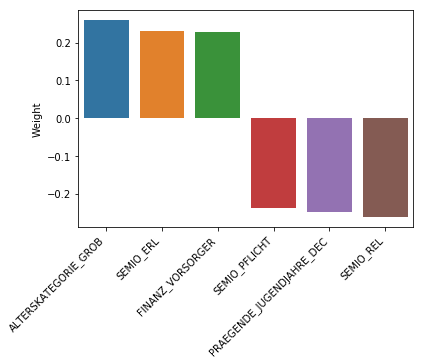

In [74]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc2 = map_weight(pc=2)
sns.barplot(pc2[0],pc2[1])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Weight")

plt.show()

ALTERSKATEGORIE_GROB: Estimated age based on given name analysis

SEMIO_ERL: personality event-oriented

FINANZ_VORSORGER: financial be prepared

SEMIO_PFLICHT: dutiful

PRAEGENDE_JUGENDJAHRE_DEC: Dominating movement of person's youth

SEMIO_REL: religious

PC2: Related to age of the person, how much they spend and their personalities or motivations 

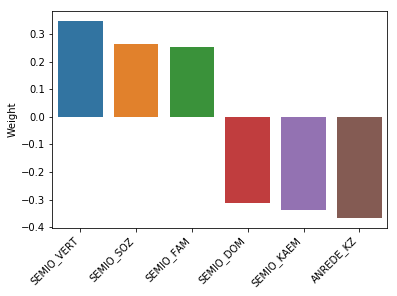

In [75]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pc3 = map_weight(pc=3)
sns.barplot(pc3[0],pc3[1])
plt.xticks(rotation=45, ha='right')
plt.ylabel("Weight")

plt.show()

SEMIO_VERT: dreamful   

SEMIO_SOZ: socially-minded    

SEMIO_FAM: family-minded      


SEMIO_DOM: dominant-minded   

SEMIO_KAEM: combative attitude  

ANREDE_KZ: Gender   

PC3: feature related to gender and behavior in society or groups, society or independent

### Discussion 2.3: Interpret Principal Components

I analyzed the 3 first PC.

PC1: how many families lives in an unit. More families per unite have positive values, and less families per unit have negative values.

PC2: expenditure and mindset. People that expend more and are event-oriented have positive values, while religious or with a sense of duty persons have negative values.

PC3: individualism. People more socially or family oriented have positive values, while people more individualist (dominant or combative) have negative values.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
# Over a number of different cluster counts...

n_clusters = 15
score = []
    # run k-means clustering on the data and...
for cluster in range(1,n_clusters):
    kmeans = KMeans(n_clusters=cluster, random_state=0).fit(pca_general_pop)    
    score.append(kmeans.score(pca_general_pop))


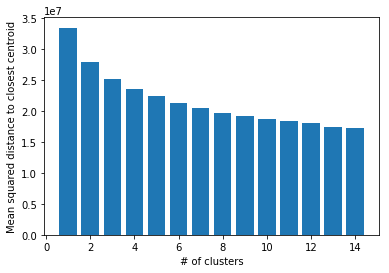

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

score_array = np.array(score)
score_array = score_array * -1
plt.bar(range(1,n_clusters), score_array)
plt.xlabel("# of clusters")
plt.ylabel("Mean squared distance to closest centroid")
plt.show()


In [78]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# initialization of kmeans
kmeans = KMeans(n_clusters=12, random_state=0, n_init = 50)

# fit model to data
kmeans_model = kmeans.fit(pca_general_pop)

# predict labels over general pop dataset scaled and with less dimensions
y_pred = kmeans_model.predict(pca_general_pop)

### Discussion 3.1: Apply Clustering to General Population


I tested clustering with 1 to 15 clusters, but the mean square distance to closest centroid did not change much from using 12 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [79]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [80]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

print("Customer dataset shape: ", customers.shape)

# preprocessing
customers_preproc = []
customers_preproc = clean_data(customers)

# feature transformation
# subset without any nan value
customers_clean = customers_preproc[~customers_preproc.isnull().any(axis=1)]

print("Customer dataset shape without any nan value: ", customers.shape)

Customer dataset shape:  (191652, 85)
Customer dataset shape without any nan value:  (191652, 79)


In [81]:
# add dummies columns to have the same columns than general population
# function from Udacity knowleadge 
def add_missing_dummy_columns(d, columns):
    missing_cols = set(columns) - set(d.columns)
    print(missing_cols)
    for c in missing_cols:
        d[c] = 0
           
def fix_columns(d, columns):  
    add_missing_dummy_columns(d, columns)
    # make sure we have all the columns we need
    assert(set(columns) - set(d.columns) == set())
    extra_cols = set(d.columns) - set(columns)
    if extra_cols:
        print("extra columns:", extra_cols)
    d = d[columns]
    return d

customers_dummy = fix_columns(customers_clean, subset1_clean.columns.tolist())
customers_dummy.shape[1]

set()


66

In [82]:
# Apply feature scaling to the general population demographics data.
df_columns = customers_dummy.columns.tolist()
customers_scaled = customers_dummy.copy()
customers_transform = scaler.transform(customers_dummy)

In [83]:
# labeling using previous cluster model from general population
pca_customers = pca_reduced.transform(customers_transform)
y_customers = kmeans_model.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

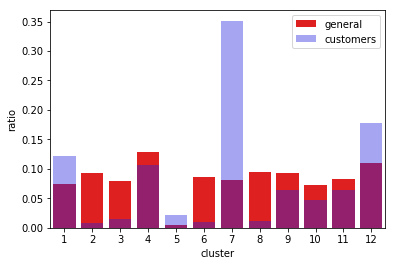

In [84]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

unique_general, counts_general = np.unique(y_pred, return_counts=True)
y_pred_ratio = counts_general / len(y_pred)

unique_cus, counts_cus = np.unique(y_customers, return_counts=True)
y_customers_ratio = counts_cus / len(y_customers)

sns.barplot(x= np.arange(1,13), y=y_pred_ratio, color = 'r', label = "general")
sns.barplot(x= np.arange(1,13), y=y_customers_ratio, color = 'b', 
           label = 'customers', alpha  = 0.4)
plt.xlabel("cluster")
plt.ylabel("ratio")
plt.legend()

plt.show()

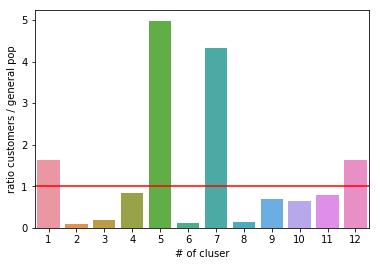

Cluster overrepresented in customers:  [1, 5, 7, 12]
Cluster underrepresented in customers:  [2, 3, 4, 6, 8, 9, 10, 11]


In [85]:
ratio_pred = counts_general/len(y_pred)
ratio_customers = counts_cus/len(y_customers)
ratio = ratio_customers/ratio_pred
df_ratio = pd.DataFrame(ratio, columns = ['ratio'], index = np.arange(1,13))
under = df_ratio[df_ratio.ratio<1].index.tolist()
over = df_ratio[df_ratio.ratio>1].index.tolist()

sns.barplot(x= df_ratio.index.tolist(), y=df_ratio.ratio)
plt.axhline(y=1, color = 'r')
plt.xlabel("# of cluser")
plt.ylabel("ratio customers / general pop")
plt.show()

print("Cluster overrepresented in customers: ", over)
print("Cluster underrepresented in customers: ", under)

In [86]:
def kind_people(cluster, pca_people, y_people):
    people_recovered = pca_reduced.inverse_transform(pca_people[y_people == cluster-1])
    cluster_center = kmeans_model.cluster_centers_[cluster-1]
    
    pc_over = map_weight(components = people_recovered, pc=1)

    sns.barplot(pc_over[0], pc_over[1])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Weight")

    plt.show()

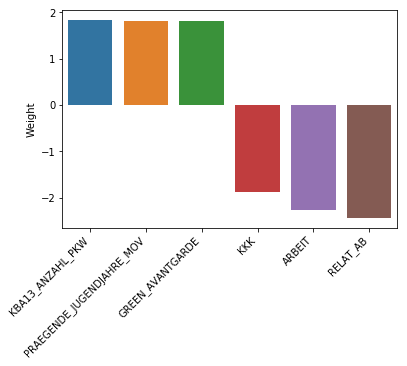

In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Overrepresented cluster in customers

kind_people(7, pca_customers, y_customers)

KBA13_ANZAHL_PKW : Number of cars in the PLZ8 region

PRAEGENDE_JUGENDJAHRE_MOV: movement when people born

GREEN_AVANTGARDE:  Membership in environmental sustainability as part of youth

KKK:  Purchasing power in region

ARBEIT: Share of unemployment in community

RELAT_AB: Share of unemployment relative to county in which community is contained

Cluster 7 is related with purchase power and employment

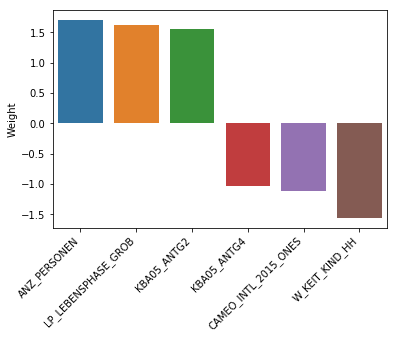

In [91]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Underrepresented cluster in customers

kind_people(4, pca_customers, y_customers)

ANZ_PERSONEN: Number of adults in household

LP_LEBENSPHASE_GROB: Life stage, rough scale

KBA05_ANTG2: Number of 3-5 family houses in the microcell

KBA05_ANTG4:  Number of 10+ family houses in the microcell

CAMEO_INTL_2015_ONES: Life stage

W_KEIT_KIND_HH:  Likelihood of children in household

Group 4 is related to age

### Discussion 3.3: Compare Customer Data to Demographics Data

Customers are overrepresented in the clusters 1, 5, 7 adn 12, and underrepresented in the clusters 2, 3, 4, 6, 8, 9, 10, 11. 

Cluster 7, an example of a cluster in which the customers are overrepresented, combine features related to purchase power and employment. Customers tend to have jobs and have more purchase power.

Cluster 4, and example of a group underrepresented in the customers, combine features related to age. Customers tend to be younger.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.